In [1]:
from functools import partial
import os
import yaml
import torch
from guided_diffusion.unet import create_model,create_model_ir
from guided_diffusion.gaussian_diffusion import create_sampler
from util.logger import get_logger
import cv2
import numpy as np
from skimage.io import imsave
import warnings
import shutil
import matplotlib.pyplot as plt
from util.utils import image_read,load_yaml,norm_img,tensor_to_numpy
warnings.filterwarnings('ignore')

sampler_type = "d3fm_fusion" # ddim/d3fm/d3fm_suion

In [2]:
img_name = "FLIR_08248.jpg"
vi_img_folder = "/home/2021/hexin/XJ2/RoadScene/crop_LR_visible"
ir_img_folder = "/home/2021/hexin/XJ2/RoadScene/cropinfrared"
vi_dst_path = "/home/2021/hexin/XJ2/D3FM/input2/vi"
ir_dst_path = "/home/2021/hexin/XJ2/D3FM/input2/ir"
shutil.copy(os.path.join(vi_img_folder, img_name), vi_dst_path)
shutil.copy(os.path.join(ir_img_folder, img_name), ir_dst_path)
# Directly set arguments here for Jupyter Notebook
class Args:
    model_config = 'configs/vi_model_config_imagenet.yaml'
    ir_model_config = 'configs/ir_model_config_imagenet.yaml'
    diffusion_config = 'configs/diffusion_config.yaml'
    d3fm_f_diffusion_config = 'configs/d3fm_f_diffusion_config.yaml'
    d3fm_diffusion_config = 'configs/d3fm_diffusion_config.yaml'
    save_dir = f'./output2/${sampler_type}'

args = Args()
logger = get_logger()
device = "cuda:0"

out_path = args.save_dir
os.makedirs(out_path, exist_ok=True)
for img_dir in ['recon', 'progress']:
    os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


inf_img shape : torch.Size([1, 3, 288, 480]), vis_img shape : torch.Size([1, 3, 288, 480]), x_start shape : torch.Size([1, 3, 288, 480])
torch.Size([1, 3, 288, 480])
(288, 480, 3)


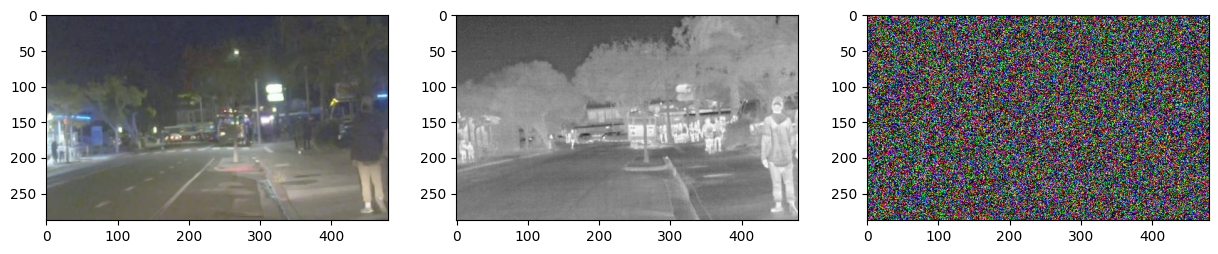

In [3]:

mode = 'RGB' #RGB:[1,1,H,W,3] GRAY:[1,1,H,W]
ir_img = image_read(os.path.join(vi_img_folder,img_name),mode=mode)[np.newaxis,np.newaxis, ...]/255.0 
vi_img = image_read(os.path.join(ir_img_folder,img_name), mode=mode)[np.newaxis,np.newaxis, ...]/255.0 

#inf_img = inf_img*2-1
#vis_img = vis_img*2-1

if mode == "RGB":
    #  (B, H, W, C)
    ir_img = np.squeeze(ir_img, axis=1)  
    vi_img = np.squeeze(vi_img, axis=1) 
    #  (B, C, H, W)
    ir_img = np.transpose(ir_img, (0, 3, 1, 2))  
    vi_img = np.transpose(vi_img, (0, 3, 1, 2)) 

# crop to make divisible
scale = 32
h, w = ir_img.shape[2:]
h = h - h % scale
w = w - w % scale

ir_img = ((torch.FloatTensor(ir_img))[:,:,:h,:w]).to(device)
vi_img = ((torch.FloatTensor(vi_img))[:,:,:h,:w]).to(device)

assert ir_img.shape == vi_img.shape

if mode == "RGB":# (1, 3, H, W)
    x_start = torch.randn(ir_img.shape, device=device)  
elif mode == "GRAY":# (1, 1, H, W)
    # x_start = torch.randn((ir_img.repeat(1, 3, 1, 1)).shape, device=device)  
    x_start = torch.randn_like(ir_img, device=device)

# Sampling
seed = 3407
torch.manual_seed(seed)
print(f"inf_img shape : {ir_img.shape}, vis_img shape : {vi_img.shape}, x_start shape : {x_start.shape}")

# Convert tensors to numpy arrays
print(ir_img.shape) # e([1, 3, 288, 480])
inf_np = tensor_to_numpy(ir_img.squeeze().permute(1, 2, 0))
vis_np = tensor_to_numpy(vi_img.squeeze().permute(1, 2, 0))
x_np = tensor_to_numpy(x_start.squeeze().permute(1, 2, 0))
print(inf_np.shape) # (288, 480, 3)
# 创建子图
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 显示原始RGB图像
axs[0].imshow(inf_np)
axs[1].imshow(vis_np)
axs[2].imshow(x_np)
# 显示图像
plt.show()

In [4]:

# 如果要用红外预训练diffusion模型，改成 ir_model_config
model_config = load_yaml(args.model_config) 
model = create_model(**model_config)  




model = model.to(device)
model.eval()

if(sampler_type == "d3fm_fusion"):
    # 混合扩散
    d3fm_f_diffusion_config = load_yaml(args.d3fm_f_diffusion_config)
    sampler = create_sampler(**d3fm_f_diffusion_config) 
    ir_sampler = create_sampler(**d3fm_f_diffusion_config) 
    sampler.set_ir_sampler(ir_sampler)
    # 红外预训练的模型
    ir_model_config = load_yaml(args.ir_model_config) 
    ir_model = create_model_ir(**ir_model_config)  
    ir_model = ir_model.to(device)
    ir_model.eval()
    sample_fn = partial(sampler.p_sample_loop_viir, model = model, ir_model = ir_model)
elif(sampler_type == "d3fm"):
    d3fm_diffusion_config = load_yaml(args.d3fm_diffusion_config)
    sampler = create_sampler(**d3fm_diffusion_config) 
    ir_model_config = load_yaml(args.ir_model_config) 
    ir_model = create_model_ir(**ir_model_config)  
    ir_model = ir_model.to(device)
    ir_model.eval()
    sample_fn = partial(sampler.p_sample_loop_viir, model = model, ir_model = ir_model)
else:
    diffusion_config = load_yaml(args.diffusion_config)
    sampler = create_sampler(**diffusion_config) 
    sample_fn = partial(sampler.p_sample_loop, model = model)

FileNotFoundError: [Errno 2] No such file or directory: 'configs/d3fm_f_diffusion_config.yaml'

In [ ]:
with torch.no_grad(): # rho=0.001
    sample = sample_fn(x_start=x_start, record=True, I = ir_img, V = vi_img, save_root=out_path, img_index = os.path.splitext(img_name)[0], lamb=0.5, rho=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 3, 288, 480])
(288, 480, 3)


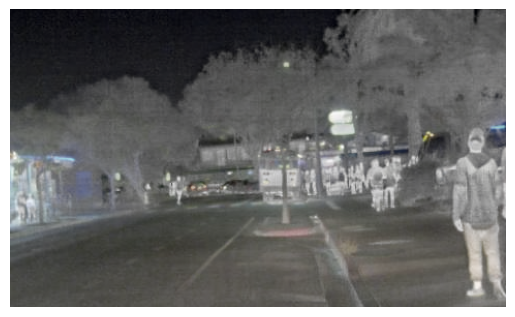

2024-07-31 09:22:23,851 [DPS] >> Save result in ./output2/recon  FLIR_08248.jpg


In [ ]:
print(sample.shape)
rgb_image = sample.squeeze().permute(1, 2, 0).cpu().numpy()
print(rgb_image.shape)
sample_norm=norm_img(rgb_image)
# 显示图像
plt.imshow(sample_norm)
plt.axis('off')  # 关闭坐标轴
plt.show()
save_path = os.path.join(out_path, 'recon')

if not os.path.exists(save_path):
    os.makedirs(save_path)
save_name = "{}.png".format(img_name.split(".")[0])
imsave(os.path.join(save_path, save_name),sample_norm)
logger.info(f"Save result in {save_path}  {img_name}")